# Movie Recommendation System using PyTorch

## 1. Introduction
In this notebook, we will build a simple **Matrix Factorization** model using **PyTorch** to recommend movies to users. 
This approach learns low-dimensional embeddings for both users and movies, allowing us to predict how a user would rate a movie they haven't seen yet. This is a fundamental technique used by companies like Netflix and Amazon.

### Key Concepts:
- **Collaborative Filtering**: Making predictions based on the past behavior of similar users.
- **Embeddings**: Representing users and movies as dense vectors in a latent space.
- **Dot Product**: Estimating affinity (rating) by the dot product of user and movie vectors.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np

# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

## 2. Generating a Dummy Dataset
To simulate a real-world scenario, we'll create a small dataset with:
- **Users**: Simulated user IDs (20 users).
- **Movies**: A list of 10 popular movie titles with associated genres.
- **Ratings**: Random ratings between 1 and 5, representing specific user preferences.

In [ ]:
# 1. Define dummy movies with IDs
movies_data = [
    (0, "The Matrix", "Action"),
    (1, "Inception", "Sci-Fi"),
    (2, "The Godfather", "Crime"),
    (3, "Toy Story", "Animation"),
    (4, "Pulp Fiction", "Crime"),
    (5, "The Dark Knight", "Action"),
    (6, "Interstellar", "Sci-Fi"),
    (7, "Forrest Gump", "Drama"),
    (8, "Frozen", "Animation"),
    (9, "Avengers: Endgame", "Action"),
    (10, "The Shawshank Redemption", "Drama"),
    (11, "Gladiator", "Action"),
    (12, "Spirited Away", "Animation"),
    (13, "Parasite", "Thriller"),
    (14, "The Lion King", "Animation"),
    (15, "Fight Club", "Drama"),
    (16, "Blade Runner 2049", "Sci-Fi"),
    (17, "Joker", "Crime"),
    (18, "Spider-Man: Into the Spider-Verse", "Animation"),
    (19, "The Silence of the Lambs", "Thriller"),
    (20, "Star Wars: A New Hope", "Sci-Fi"),
    (21, "Saving Private Ryan", "War"),
    (22, "Jurassic Park", "Adventure"),
    (23, "The Lord of the Rings: The Fellowship of the Ring", "Adventure"),
    (24, "Coco", "Animation"),
    (25, "The Departed", "Crime"),
    (26, "The Shining", "Horror"),
    (27, "Goodfellas", "Crime"),
    (28, "Alien", "Sci-Fi"),
    (29, "The Prestige", "Drama"),
    (30, "Memento", "Mystery"),
    (31, "Seven", "Thriller"),
    (32, "Mad Max: Fury Road", "Action"),
    (33, "Logan", "Action"),
    (34, "Your Name", "Animation"),
    (35, "Arrival", "Sci-Fi"),
    (36, "The Wolf of Wall Street", "Biography"),
    (37, "Whiplash", "Drama"),
    (38, "Django Unchained", "Western"),
    (39, "Inglourious Basterds", "War"),
    (40, "La La Land", "Romance"),
    (41, "The Grand Budapest Hotel", "Comedy"),
    (42, "The Truman Show", "Comedy"),
    (43, "A Clockwork Orange", "Sci-Fi"),
    (44, "Psycho", "Horror"),
    (45, "No Country for Old Men", "Crime"),
    (46, "Up", "Animation"),
    (47, "Terminator 2: Judgment Day", "Action"),
    (48, "Back to the Future", "Sci-Fi"),
    (49, "Heat", "Crime")
]
movies_df = pd.DataFrame(movies_data, columns=['movie_id', 'title', 'genre'])

# 2. Generate random ratings
num_users = 20
num_ratings = 200

# Randomly assign users to movies with random ratings
user_ids = np.random.randint(0, num_users, num_ratings)
movie_ids = np.random.randint(0, len(movies_df), num_ratings)
ratings = np.random.randint(1, 6, num_ratings)

ratings_df = pd.DataFrame({
    'user_id': user_ids,
    'movie_id': movie_ids,
    'rating': ratings
})


# Remove duplicates (simulate keeping the latest rating if a user rated twice)
ratings_df = ratings_df.drop_duplicates(subset=['user_id', 'movie_id'], keep='last')

# Prepare Genre Mapping
unique_genres = movies_df['genre'].unique()
genre_to_idx = {genre: i for i, genre in enumerate(unique_genres)}
movies_df['genre_id'] = movies_df['genre'].map(genre_to_idx)

# Map genre IDs to ratings dataframe
# We map from movie_id to ensure every rating row gets the correct genre
ratings_df['genre_id'] = ratings_df['movie_id'].map(movies_df.set_index('movie_id')['genre_id'])

print(f"Genre Map: {genre_to_idx}")
print("Movies DataFrame:")
display(movies_df.head())
print("\nRatings DataFrame:")
display(ratings_df.head())


## 3. Data Preparation
We need to prepare the data for training. Pytorch models require data to be in the form of **Tensors**.
We will convert our User IDs, Movie IDs, and Ratings into tensors.

However, in real production systems (Netflix, TikTok, e-commerce, etc.), data preparation is not done manually inside notebook. Instead, companies use a Feature Store.

### What is Feature Store?

A feature store is a centralized system that:
- collects ML features from data warehouse
- ensures consistent features for training & inference
- provides versioned and reusable features
- prevents training-serving skew

### Popular tools:

- Feast (most popular open-source)
- Tecton
- Databricks Feature Store

In [ ]:
# Convert to tensors
# LongTensor is used for indices (discrete values)
# FloatTensor is used for ratings (continuous values)
user_tensor = torch.LongTensor(ratings_df['user_id'].values)
movie_tensor = torch.LongTensor(ratings_df['movie_id'].values)
genre_tensor = torch.LongTensor(ratings_df['genre_id'].values)
rating_tensor = torch.FloatTensor(ratings_df['rating'].values)

print(f"Total unique ratings available for training: {len(rating_tensor)}")
print(f"Genre Tensor shape: {genre_tensor.shape}")


## 4. Building the Matrix Factorization Model
We will define a PyTorch `nn.Module` class named `RecommenderNet`.

**Architecture Details:**
1. **Embeddings**: We create three embedding layers: Users, Movies and Genres. These map the sparse IDs to a dense vector of size `embedding_size` (e.g., 32).
2. **Forward Pass**: We look up the embeddings for the input user and movie, multiply them element-wise, and sum them up (Dot Product). This results in a single predicted score.


In [ ]:
# --- 4. Building the Matrix Factorization Model ---
class RecommenderNet(nn.Module):
    def __init__(self, num_users, num_movies, num_genres, embedding_size=16):
        super(RecommenderNet, self).__init__()
        # Embeddings: A lookup table that stores embeddings of a fixed dictionary and size.
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.movie_embedding = nn.Embedding(num_movies, embedding_size)
        self.genre_embedding = nn.Embedding(num_genres, embedding_size)
        
    def forward(self, user_indices, movie_indices, genre_indices):
        # Retrieve embeddings for the specific users and movies in the batch
        user_embed = self.user_embedding(user_indices)
        movie_embed = self.movie_embedding(movie_indices)
        genre_embed = self.genre_embedding(genre_indices)
        
        # Dot product: Multiply vectors and sum across the embedding dimension
        # We add the genre embedding to the movie embedding to enrich the item representation
        # Shape: (Batch_Size, Embedding_Size) -> (Batch_Size)

        predicted_rating = (user_embed * (movie_embed + genre_embed)).sum(dim=1)

        # score = torch.sum(user_embed * (movie_embed + genre_embed), dim=1)
        # predicted_rating = torch.sigmoid(score) * 4 + 1

        return predicted_rating

# Instantiate the model
# We strictly define num_users and num_movies based on our dataset limits
model = RecommenderNet(num_users=num_users, num_movies=len(movies_df), num_genres=len(unique_genres))
print(model)


## 5. Training the Model
We use **Mean Squared Error (MSE)** as our loss function because we are predicting a continuous value (the rating).
We use the **Adam** optimizer for efficient gradient descent.

### Model Versioning
In real company environments, machine learning models are not trained only once.
They are continuously retrained because:
- New users join
- New movies added
- User preferences change
- More rating/watch history collected

### Model Repository
In real production system, model is stored in model repository, not local folder.

Popular tools:
- MLflow Model Registry
- AWS Sagemaker Model Registry
- Google Vertex AI Model Registry
- Huggingface model hub

### PyTorch Model Type + Loss Function Mapping
- Predict number (price, rating) -> MSELoss
- Yes/No prediction -> BCEWithLogitsLoss
- Multi-class classification -> CrossEntropyLoss
- Recommendation rating prediction -> MSELoss
- Vector similarity -> CosineEmbeddingLoss
- Ranking recommendation -> Ranking/BPR loss

In [ ]:
# --- 5. Training the Model ---
# 1. Define Loss and Optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 2. Training Loop
epochs = 200
print("Starting training...")

for epoch in range(epochs):
    optimizer.zero_grad() # Clear previous gradients
    
    # Forward pass: Compute predicted ratings
    predictions = model(user_tensor, movie_tensor, genre_tensor)
    
    # Compute loss: Compare predictions with actual ratings
    loss = loss_fn(predictions, rating_tensor)
    
    # Backward pass: Compute gradients and update weights
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 20 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

print("Training complete.")

## 6. Making Recommendations
Now that the model is trained, we can recommend movies to a specific user.
The process is:
1. Identify movies the user *has not* seen.
2. Predict the user's rating for those movies using our trained model.
3. Sort by highest predicted rating to find the best recommendations.

In [ ]:
# --- 6. Making Recommendations ---
def recommend_movies(user_id, model, movies_df, ratings_df, num_recommendations=3):
    # Get all movie IDs available
    all_movie_ids = torch.arange(len(movies_df))
    
    # Get movies already rated by the user so we don't recommend them again
    rated_movie_ids = ratings_df[ratings_df['user_id'] == user_id]['movie_id'].values
    
    # Filter out watched movies
    movies_to_predict = [m_id for m_id in all_movie_ids.tolist() if m_id not in rated_movie_ids]
    
    if not movies_to_predict:
        return []
    
    # Prepare input tensors for the model
    movies_tensor_pred = torch.LongTensor(movies_to_predict)
    user_tensor_pred = torch.LongTensor([user_id] * len(movies_to_predict))
    
    # Get genre indices for the movies
    # Map movie_id to genre_id using the movies_df
    movie_genre_map = movies_df.set_index('movie_id')['genre_id']
    genres_list = [movie_genre_map[m_id] for m_id in movies_to_predict]
    genre_tensor_pred = torch.LongTensor(genres_list)
    
    # Predict ratings for unwatched movies
    with torch.no_grad():
        predictions = model(user_tensor_pred, movies_tensor_pred, genre_tensor_pred)
    
    # Sort predictions (descending order) to get top rated movies
    # torch.argsort returns the INDICES of the sorted values
    sorted_indices = torch.argsort(predictions, descending=True)
    
    top_indices = sorted_indices[:num_recommendations]
    
    recommended_movie_ids = movies_tensor_pred[top_indices].numpy()
    predicted_ratings = predictions[top_indices].numpy()
    
    # Fetch movie details for the results
    results = []
    for m_id, pred_rating in zip(recommended_movie_ids, predicted_ratings):
        movie_info = movies_df[movies_df['movie_id'] == m_id].iloc[0]
        results.append((movie_info['title'], movie_info['genre'], pred_rating))
        
    return results


In [ ]:
# --- TEST THE SYSTEM ---
user_id_to_test = 0
print(f"generating recommendations for User ID {user_id_to_test}...")

recommendations = recommend_movies(user_id_to_test, model, movies_df, ratings_df)

if recommendations:
    for title, genre, rating in recommendations:
        print(f"Recommend: '{title}' ({genre}) - Predicted Rating: {rating:.2f}")
else:
    print("No movies left to recommend!")

print('')
print(ratings_df[ratings_df['user_id'] == user_id_to_test].merge(movies_df, on='movie_id')[['movie_id','title','genre','genre_id_x','rating']])



In [ ]:
# --- PERFORM OFFLINE CHECK ---

user_tensor_pred = torch.LongTensor([1])
movies_tensor_pred = torch.LongTensor([0])
genre_tensor_pred = torch.LongTensor([8])

print(f'user_tensor_pred : {user_tensor_pred}')
print(f'movies_tensor_pred : {movies_tensor_pred}')
print(f'genre_tensor_pred : {genre_tensor_pred}')

predictions = model(user_tensor_pred, movies_tensor_pred, genre_tensor_pred)

print(f'predictions : {predictions.detach().numpy()}')


## 7. Model Evaluation & Testing (Machine Learning Lifecycle)
After training a machine learning model, we must evaluate its performance before deploying it to production.
Evaluation ensures that the model:
- predicts accurately
- generalizes to new users
- does not overfit training data
- is better than previous model version

### Model Evaluation Pipeline
Feature Store → Training → Evaluation → Model Registry → Deploy → Monitor


## 8. Machine Learning Architecture

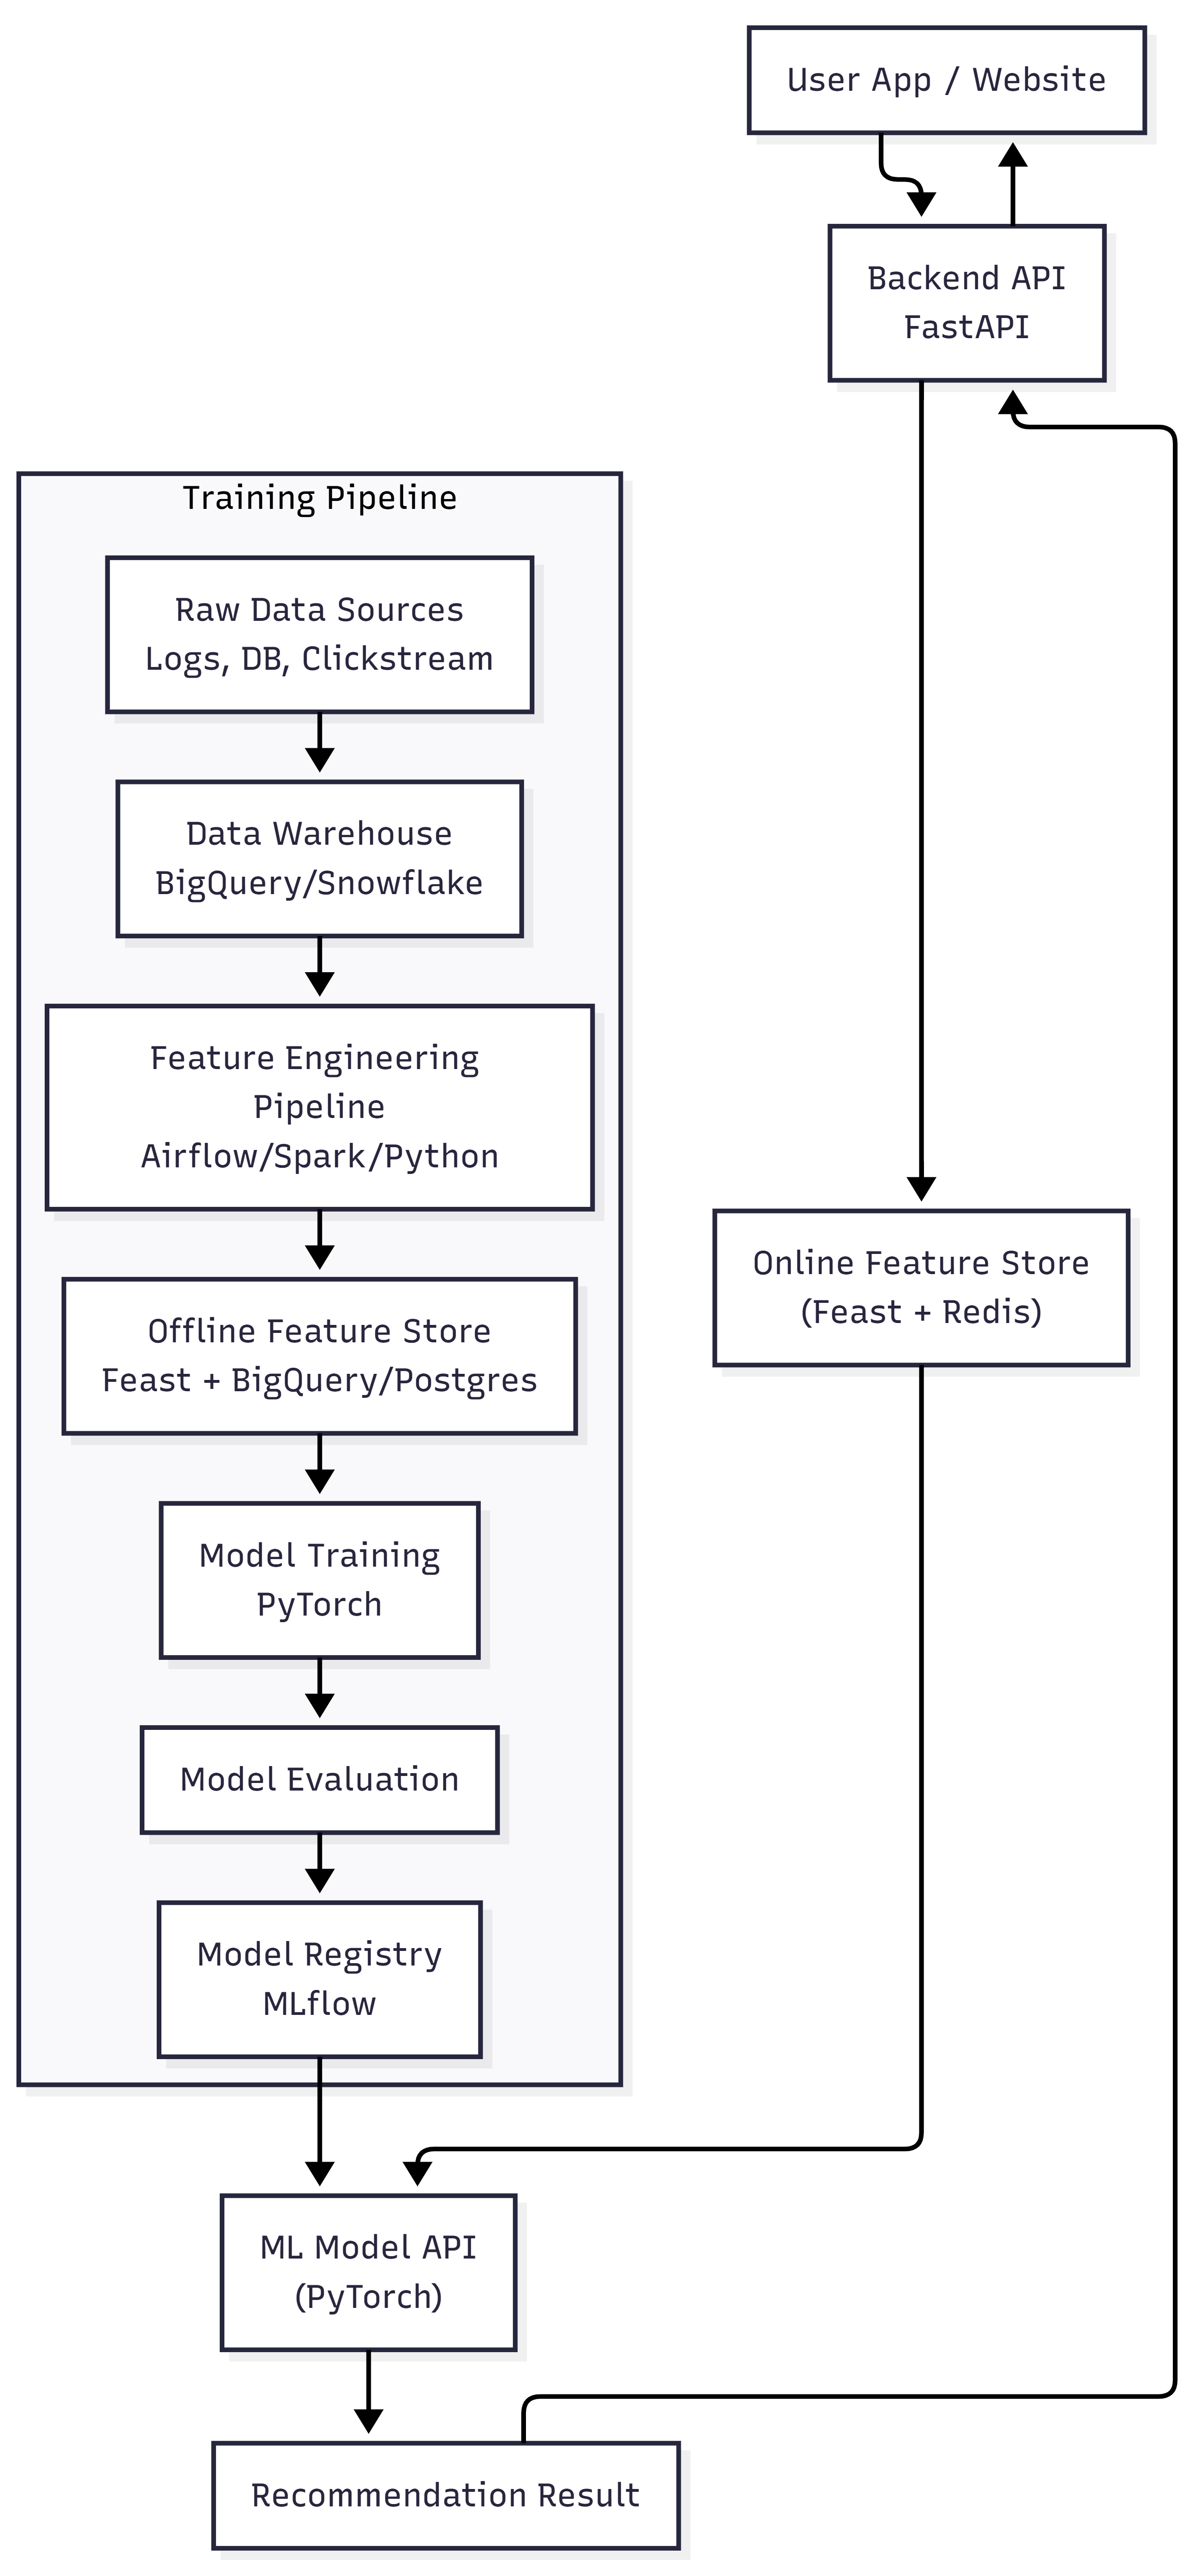